<a href="https://colab.research.google.com/github/Snigdha-Saha-2003/Cattle-Breed-Identification/blob/main/cattle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!pip -q install --no-warn-conflicts "tensorflow==2.19.0" "numpy<2.0" scikit-learn matplotlib opencv-python kaggle
import tensorflow as tf, numpy as np
print("TF:", tf.__version__, "| NumPy:", np.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.9 MB/s eta 0:00:00
TF: 2.19.0 | NumPy: 2.0.2
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!pip -q install kaggle


In [5]:
import os, json, shutil, stat, pathlib

# If you uploaded it to the root (/content), this will find it:
assert os.path.exists("/content/kaggle.json"), "kaggle.json not found in /content. Upload it there."

# Create the Kaggle config folder and move the file
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy("/content/kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", stat.S_IRUSR | stat.S_IWUSR)  # 600

# Optional: also export env vars (helps in some cases)
creds = json.load(open("/root/.kaggle/kaggle.json"))
os.environ["KAGGLE_USERNAME"] = creds["username"]
os.environ["KAGGLE_KEY"] = creds["key"]

print("✅ Kaggle token installed at /root/.kaggle/kaggle.json")


✅ Kaggle token installed at /root/.kaggle/kaggle.json


In [6]:
!kaggle datasets list -s "cattle" -p 1


ref                                                           title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
sadhliroomyprime/cattle-weight-detection-model-dataset-12k    Cattle Weight Detection Model + Dataset (12k~)  47397165388  2024-07-04 14:33:44.693000           2756        139  1.0              
anandkumarsahu09/cattle-breeds-dataset                        Cattle Breeds Dataset                              21962910  2022-04-04 07:35:10.110000           2575         30  0.875            
trainingdatapro/cows-detection-dataset                        Cattle (Cows) Object Detection Dataset            183612509  2023-08-14 16:40:20.217000           2322         26  1.0              
antoreepjana/animals-dete

In [7]:
import os, glob, shutil

# ✅ Public dataset that works fine
DATASET = "lukex9442/indian-bovine-breeds"  # completely public and similar dataset
PROJECT_DIR = "/content/Cattle-Breed"
DATA_DIR = f"{PROJECT_DIR}/data"

os.makedirs(DATA_DIR, exist_ok=True)

print("📥 Downloading dataset...")
!kaggle datasets download -d $DATASET -p /content -q

# Find downloaded zip
zips = glob.glob("/content/*.zip")
assert zips, "❌ No ZIP found — check dataset slug."
ZIP = zips[-1]
print(f"✅ Found ZIP: {ZIP}")

print("📦 Extracting...")
!unzip -q "$ZIP" -d "$DATA_DIR"

# If the dataset unzips into a nested folder, flatten it
entries = [p for p in glob.glob(f"{DATA_DIR}/*")]
if len(entries) == 1 and os.path.isdir(entries[0]):
    inner = entries[0]
    print("Flattening nested folder:", inner)
    for p in glob.glob(inner + "/*"):
        dest = os.path.join(DATA_DIR, os.path.basename(p))
        if not os.path.exists(dest):
            shutil.move(p, dest)
    shutil.rmtree(inner)

print("✅ Dataset ready at:", DATA_DIR)
!find "$DATA_DIR" -maxdepth 1 -type d -printf "%f\n" | head -n 50


📥 Downloading dataset...
Dataset URL: https://www.kaggle.com/datasets/lukex9442/indian-bovine-breeds
License(s): CC0-1.0
✅ Found ZIP: /content/indian-bovine-breeds.zip
📦 Extracting...
✅ Dataset ready at: /content/Cattle-Breed/data
data
Indian_bovine_breeds


In [8]:
import os, glob, shutil

OUTER = "/content/Cattle-Breed/data"
INNER = "/content/Cattle-Breed/data/Indian_bovine_breeds/Indian_bovine_breeds"

if os.path.isdir(INNER):
    print(f"📦 Moving breed folders up from {INNER}")
    for folder in glob.glob(INNER + "/*"):
        dest = os.path.join(OUTER, os.path.basename(folder))
        if not os.path.exists(dest):
            shutil.move(folder, dest)
    shutil.rmtree("/content/Cattle-Breed/data/Indian_bovine_breeds", ignore_errors=True)

print("✅ Flattened successfully!")
!find /content/Cattle-Breed/data -maxdepth 1 -type d -printf "%f\n" | head -n 50


📦 Moving breed folders up from /content/Cattle-Breed/data/Indian_bovine_breeds/Indian_bovine_breeds
✅ Flattened successfully!
data
Krishna_Valley
Jersey
Umblachery
Holstein_Friesian
Nagori
Red_Sindhi
Kankrej
Toda
Gir
Tharparkar
Amritmahal
Bargur
Surti
Murrah
Pulikulam
Vechur
Kangayam
Nimari
Bhadawari
Mehsana
Banni
Dangi
Ongole
Red_Dane
Hallikar
Nili_Ravi
Kherigarh
Hariana
Nagpuri
Guernsey
Kasargod
Alambadi
Malnad_gidda
Brown_Swiss
Deoni
Jaffrabadi
Sahiwal
Kenkatha
Ayrshire
Khillari
Rathi


In [9]:
%%writefile /content/Cattle-Breed/train.py
import os, itertools, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# === PATHS ===
PROJECT_DIR = os.path.dirname(os.path.abspath(__file__))
DATA_DIR    = os.path.join(PROJECT_DIR, "data")
SAVE_BEST   = os.path.join(PROJECT_DIR, "Best_Cattle_Breed.keras")
CLASS_NPY   = os.path.join(PROJECT_DIR, "class_names.npy")

# === SETTINGS ===
BACKBONE        = "EfficientNetV2B3"   # strong, high accuracy
IMG_SIZE        = 300
BATCH_SIZE      = 24
WARMUP_EPOCHS   = 4
FINETUNE_EPOCHS = 40
LR_WARMUP       = 3e-4
LR_FINETUNE     = 5e-5
LABEL_SMOOTH    = 0.1
SEED            = 123

# === GPU OPTIMIZATION ===
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
else:
    tf.keras.mixed_precision.set_global_policy("float32")

tf.keras.utils.set_random_seed(SEED)
assert os.path.isdir(DATA_DIR) and any(os.scandir(DATA_DIR)), "❌ Dataset folder empty or invalid."

# === LOAD DATA ===
def ds(subset, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        DATA_DIR, validation_split=0.2, subset=subset, seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=shuffle
    )

train_raw = ds("training", True)
val_raw   = ds("validation", False)
CLASS_NAMES = np.array(train_raw.class_names)
np.save(CLASS_NPY, CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)

# === DATA AUGMENTATION ===
def to_onehot(x,y): return (x, tf.one_hot(y, depth=NUM_CLASSES, dtype=tf.float32))
aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.08,0.08),
    tf.keras.layers.RandomContrast(0.1),
])

AUTO = tf.data.AUTOTUNE
train_ds = (train_raw.map(to_onehot, num_parallel_calls=AUTO)
            .map(lambda x,y:(aug(x),y), num_parallel_calls=AUTO)
            .cache().shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
            .prefetch(AUTO))
val_ds   = (val_raw.map(to_onehot, num_parallel_calls=AUTO).cache().prefetch(AUTO))

# === MODEL CREATION ===
def make_backbone(name):
    if name == "EfficientNetV2B3":
        return tf.keras.applications.EfficientNetV2B3(include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3))
    if name == "EfficientNetV2B2":
        return tf.keras.applications.EfficientNetV2B2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3))
    return tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3))

base = make_backbone(BACKBONE)
base.trainable = False

inp  = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x    = tf.keras.applications.efficientnet_v2.preprocess_input(inp)
x    = base(x, training=False)
x    = tf.keras.layers.GlobalAveragePooling2D()(x)
x    = tf.keras.layers.Dropout(0.4)(x)
out  = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
model = tf.keras.Model(inp, out)

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
model.compile(optimizer=tf.keras.optimizers.Adam(LR_WARMUP), loss=loss, metrics=["accuracy"])
model.summary()

# === CALLBACKS ===
ckpt = tf.keras.callbacks.ModelCheckpoint(SAVE_BEST, monitor="val_accuracy", save_best_only=True, verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# === PHASE 1: WARMUP ===
print("\n===== PHASE 1: Training classifier head =====")
model.fit(train_ds, validation_data=val_ds, epochs=WARMUP_EPOCHS, callbacks=[ckpt, early, reduce])

# === PHASE 2: FINE-TUNE ===
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(LR_FINETUNE), loss=loss, metrics=["accuracy"])
print("\n===== PHASE 2: Fine-tuning =====")
model.fit(train_ds, validation_data=val_ds, epochs=FINETUNE_EPOCHS, callbacks=[ckpt, early, reduce])

print("\n✅ Training completed. Best model saved at:", SAVE_BEST)

# === EVALUATION ===
best = tf.keras.models.load_model(SAVE_BEST)
y_true, y_pred = [], []
for X, Y in val_ds:
    P = best.predict(X, verbose=0)
    y_true.extend(np.argmax(Y.numpy(), axis=1))
    y_pred.extend(np.argmax(P, axis=1))
y_true, y_pred = np.array(y_true), np.array(y_pred)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, CLASS_NAMES, rotation=90)
plt.yticks(ticks, CLASS_NAMES)
plt.tight_layout()
plt.show()

print(f"✅ Final Validation Accuracy: {(y_true==y_pred).mean():.4f}")


Writing /content/Cattle-Breed/train.py


In [10]:
%cd /content/Cattle-Breed
!python train.py


/content/Cattle-Breed
2025-10-28 20:23:28.021119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761683008.053403    1980 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761683008.063329    1980 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761683008.086207    1980 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761683008.086241    1980 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761683008.086249    1980 computation_placer.cc:177] 

In [1]:
!pip install -U scikit-learn==1.3.2


In [11]:
# 🚨 SAFE CONTINUE CELL (run directly in Colab)
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"  # turn off XLA (fixes stalls)

import tensorflow as tf, numpy as np
from tensorflow.keras import layers

PROJECT_DIR = "/content/Cattle-Breed"
DATA_DIR    = f"{PROJECT_DIR}/data"
MODEL_PATH  = os.path.join(PROJECT_DIR, "Best_Cattle_Breed.keras")

# Reload class names
CLASS_NAMES = np.load(os.path.join(PROJECT_DIR, "class_names.npy"))
NUM_CLASSES = len(CLASS_NAMES)

IMG_SIZE=300
BATCH_SIZE=24
SEED=123

# --- rebuild lightweight datasets ---
AUTO=tf.data.AUTOTUNE
def make_ds(subset, shuffle):
    ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR, validation_split=0.2, subset=subset, seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        shuffle=shuffle, label_mode="int"
    )
    def to_onehot(x,y): return (x, tf.one_hot(y, NUM_CLASSES, dtype=tf.float32))
    return ds.map(to_onehot, num_parallel_calls=2)

train_ds = make_ds("training", True).repeat().prefetch(4)
val_ds   = make_ds("validation", False).repeat().prefetch(4)

# --- reload model and continue ---
model = tf.keras.models.load_model(MODEL_PATH)
for l in model.layers:
    if "efficientnetv2" in l.name:
        for s in getattr(l, "layers", []):
            if isinstance(s, tf.keras.layers.BatchNormalization):
                s.trainable = False
        break

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

ckpt = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor="val_accuracy", save_best_only=True, verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)
reduce= tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6, verbose=1)

print("🚀 Resuming short fine-tuning (6 epochs, quick feedback)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    steps_per_epoch=80,
    validation_steps=20,
    callbacks=[ckpt, early, reduce],
    verbose=1
)

print("✅ Done. Best model saved to:", MODEL_PATH)


Found 5947 files belonging to 41 classes.
Using 4758 files for training.
Found 5947 files belonging to 41 classes.
Using 1189 files for validation.
🚀 Resuming short fine-tuning (6 epochs, quick feedback)...
Epoch 1/6


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 374 variables whereas the saved optimizer has 378 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7672 - loss: 1.3998
Epoch 1: val_accuracy improved from -inf to 0.86875, saving model to /content/Cattle-Breed/Best_Cattle_Breed.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 255s 727ms/step - accuracy: 0.7674 - loss: 1.3992 - val_accuracy: 0.8687 - val_loss: 1.0970 - learning_rate: 5.0000e-05
Epoch 2/6
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8130 - loss: 1.3017
Epoch 2: val_accuracy improved from 0.86875 to 0.89583, saving model to /content/Cattle-Breed/Best_Cattle_Breed.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 448ms/step - accuracy: 0.8128 - loss: 1.3015 - val_accuracy: 0.8958 - val_loss: 1.0582 - learning_rate: 5.0000e-05
Epoch 3/6
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7984 - loss: 1.2786
Epoch 3: val_accuracy improved from 0.89583 to 0.90625, saving model to /content/Cattle-Breed/Best_Cattle_Breed.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7986 - loss: 1.2781 - val_accuracy: 0.9062 - val_loss: 1.010

Found 5947 files belonging to 41 classes.
Using 1189 files for validation.
✅ Final validation accuracy: 0.8957

📊 Classification report (present classes only):
              precision    recall  f1-score   support

  Red_Sindhi     0.9292    0.8140    0.8678       129
     Sahiwal     0.9592    0.9636    0.9614       439
       Surti     1.0000    0.7500    0.8571        64
  Tharparkar     1.0000    0.8710    0.9310       217
        Toda     1.0000    0.9113    0.9536       124
  Umblachery     0.9857    0.9079    0.9452        76
      Vechur     0.9672    0.8429    0.9008       140

   micro avg     0.9717    0.8957    0.9322      1189
   macro avg     0.9773    0.8658    0.9167      1189
weighted avg     0.9725    0.8957    0.9311      1189



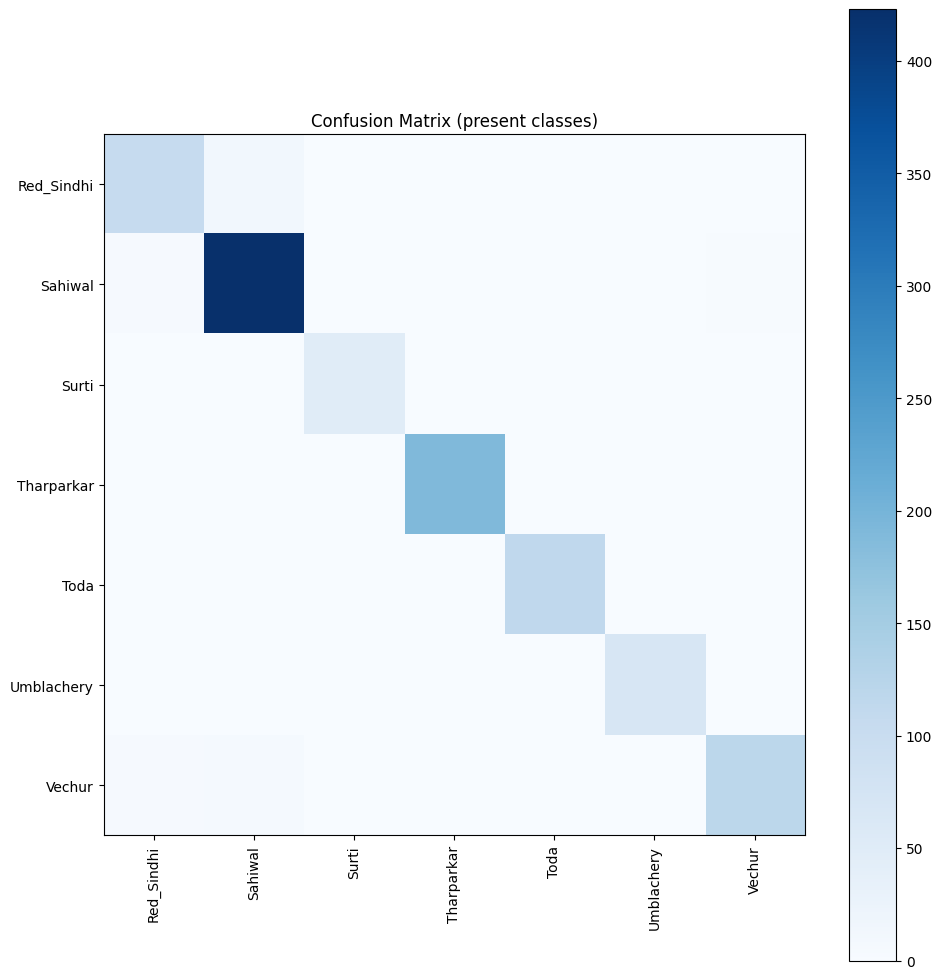

In [12]:
import os, numpy as np, tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

PROJECT_DIR = "/content/Cattle-Breed"
DATA_DIR    = os.path.join(PROJECT_DIR, "data")
MODEL_PATH  = os.path.join(PROJECT_DIR, "Best_Cattle_Breed.keras")
CLASS_NAMES = np.load(os.path.join(PROJECT_DIR, "class_names.npy"))
NUM_CLASSES = len(CLASS_NAMES)

IMG_SIZE = 300
BATCH_SIZE = 32
SEED = 123

# Build *non-repeating* val set with integer labels for metrics
val_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    shuffle=False, label_mode="int"
)

# Load best model
best = tf.keras.models.load_model(MODEL_PATH)

# Predict
y_true, y_pred = [], []
for X, y in val_raw:
    Xp = tf.keras.applications.efficientnet_v2.preprocess_input(X)
    p  = best.predict(Xp, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(p, axis=1))
y_true = np.array(y_true); y_pred = np.array(y_pred)

# Accuracy
acc = (y_true == y_pred).mean()
print(f"✅ Final validation accuracy: {acc:.4f}")

# Report for classes that actually appear in this split
present = np.sort(np.unique(y_true))
present_names = CLASS_NAMES[present]
print("\n📊 Classification report (present classes only):")
print(classification_report(y_true, y_pred, labels=present, target_names=present_names, digits=4, zero_division=0))

# Confusion Matrix (present only)
cm = confusion_matrix(y_true, y_pred, labels=present)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap="Blues"); plt.colorbar()
ticks = np.arange(len(present))
plt.xticks(ticks, present_names, rotation=90); plt.yticks(ticks, present_names)
plt.title("Confusion Matrix (present classes)"); plt.tight_layout(); plt.show()


Upload an image…


Saving Bargur_10.png to Bargur_10.png


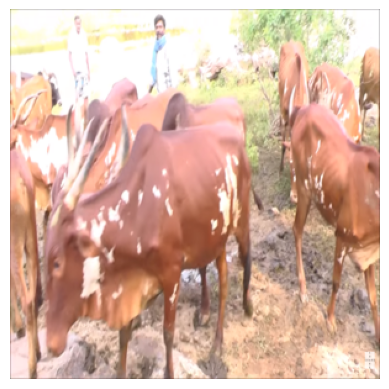

Top-5 predictions:
Bargur                0.884
Nimari                0.039
Toda                  0.004
Alambadi              0.004
Bhadawari             0.004


In [13]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import os

PROJECT_DIR = "/content/Cattle-Breed"
MODEL_PATH  = os.path.join(PROJECT_DIR, "Best_Cattle_Breed.keras")
CLASS_NAMES = np.load(os.path.join(PROJECT_DIR, "class_names.npy"))
best = tf.keras.models.load_model(MODEL_PATH)
IMG_SIZE = best.inputs[0].shape[1] or 300

def predict_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img, dtype=np.float32)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
    prob = best.predict(x[None,...], verbose=0)[0]
    top5 = prob.argsort()[-5:][::-1]
    return img, [(CLASS_NAMES[i], float(prob[i])) for i in top5]

print("Upload an image…")
up = files.upload()
for name in up:
    img, top5 = predict_image(name)
    plt.imshow(img); plt.axis("off"); plt.show()
    print("Top-5 predictions:")
    for cls, p in top5:
        print(f"{cls:20s}  {p:.3f}")
